In [6]:
import bayesflow as bf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork, DeepSet
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
import winsound

In [7]:
# Load data
rng = np.random.default_rng(1234)
data = pd.read_csv("insurance.csv", delimiter=',')
print(data.head())
print(data.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


Inspect dataset distributions

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


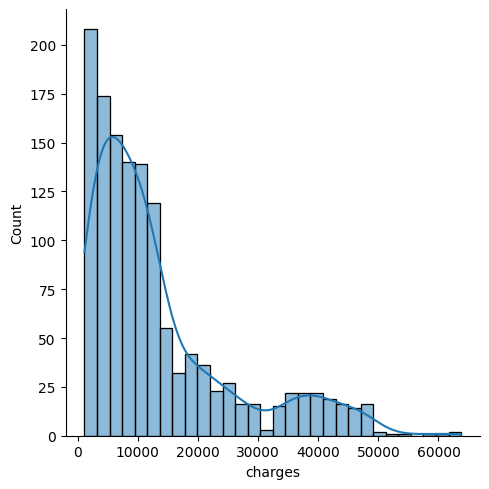

In [8]:
sns.displot(data.charges, kde=True)

We would like to predict the insurance charge given the information: age, sex, bmi, number of children children, smoker, and region  
Region, Sex, and number of children are non-informative priors, so we'll disclude them from the model (see data inspection at the bottom)
### Prior:  
$ \beta_1 \sim Gamma(0.3,2) $ Age weight  
$ \beta_2 \sim Gamma(0.79,1) $ Smoker weight  
$ \beta_3 \sim Gamma(0.2,3) $ BMI weight  
$ \sigma^2 \sim InvGamma(1,1) $ Y-intercept  
### Posterior:  
$ y \sim Normal(\beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3, \sigma^2) $  

In [9]:
# Priors
def prior_func():
    beta = rng.gamma(0.3, 2) # age weight
    s = rng.normal(0.79, 1) # smokes
    bmi = rng.gamma(0.2, 3) # bmi weight
    b0 = np.sqrt(np.power(rng.gamma(1,1), -1)) # scale
    return np.array([beta, s, bmi, b0])

prior = Prior(prior_fun=prior_func, param_names=["beta", "smokes", "bmi", "b0"])

In [10]:
# Simulator
def simulate(params, n_obs=300):
    # sample ages, smokers, and bmi
    ages = rng.uniform(18, 65, size=n_obs)
    smokes = rng.binomial(1, 0.2, size=n_obs) # 1 -> smoker
    bmis = rng.normal(30, 3, size=n_obs)
    # return draw for posterior
    res = np.zeros((n_obs, len(params-1)))
    res[:,0] = rng.normal(ages * params[0], params[3])
    res[:,1] = rng.normal(smokes * params[1], params[3])
    res[:,2] = rng.normal(bmis * params[2], params[3])
    return res

simulator = Simulator(simulator_fun=simulate)

In [11]:
model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 300, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [12]:
# debug shape
sim_data = model(4)['sim_data']
sim_data.shape

(4, 300, 4)

In [13]:
# Construct amortizer over DeepSet and InvertibleNetwork
summary_net = DeepSet()
inference_net = InvertibleNetwork(
    num_params=len(prior.param_names), 
    num_coupling_layers=6,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": True}
)
amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

Train the model

In [14]:
trainer = Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [39]:
history = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s, Epoch: 1, Iter: 1000,Loss: -6.346,Avg.Loss: -5.524,LR: 4.88E-04]
INFO:root:Validation, Epoch: 1, Loss: -6.091
Training epoch 2: 100%|██████████| 1000/1000 [00:38<00:00, 25.80it/s, Epoch: 2, Iter: 1000,Loss: -5.590,Avg.Loss: -6.276,LR: 4.52E-04]
INFO:root:Validation, Epoch: 2, Loss: -7.067
Training epoch 3: 100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s, Epoch: 3, Iter: 1000,Loss: -6.372,Avg.Loss: -6.758,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -7.470
Training epoch 4: 100%|██████████| 1000/1000 [00:38<00:00, 26.12it/s, Epoch: 4, Iter: 1000,Loss: -7.032,Avg.Loss: -6.956,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -7.737
Training epoch 5: 100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s, Epoch: 5, Iter: 1000,Loss: -7.102,Avg.Loss: -7.265,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -7.697
Training epoch 6: 100%|██████████| 1000/1000 [00

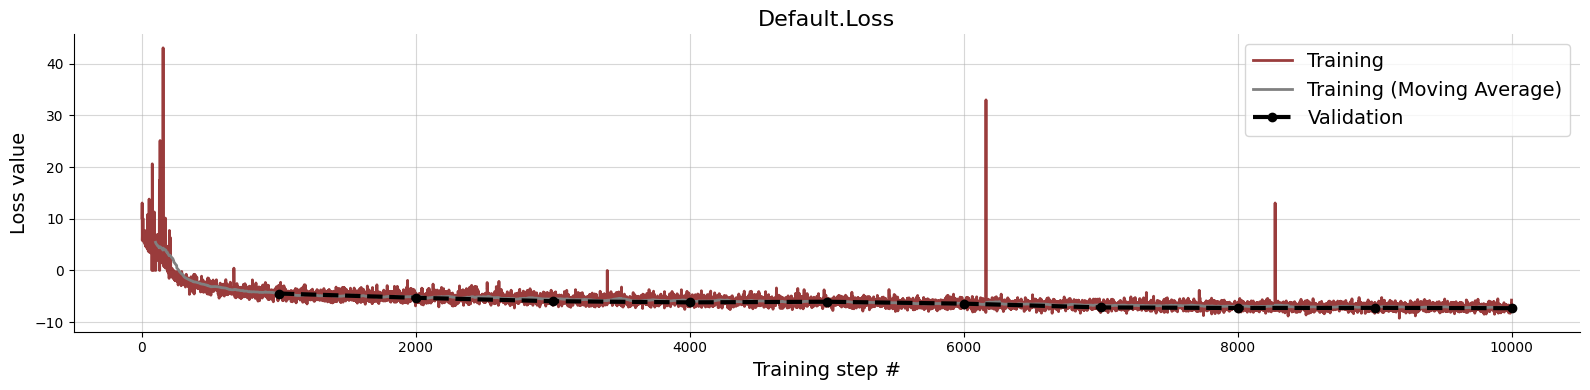

In [38]:
for i, row in enumerate(history['train_losses']['Default.Loss']):
    if row > 100:
        history['train_losses'].loc[i, 'Default.Loss'] = 0
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

dict_keys(['summary_conditions', 'direct_conditions', 'parameters'])
(300, 4)


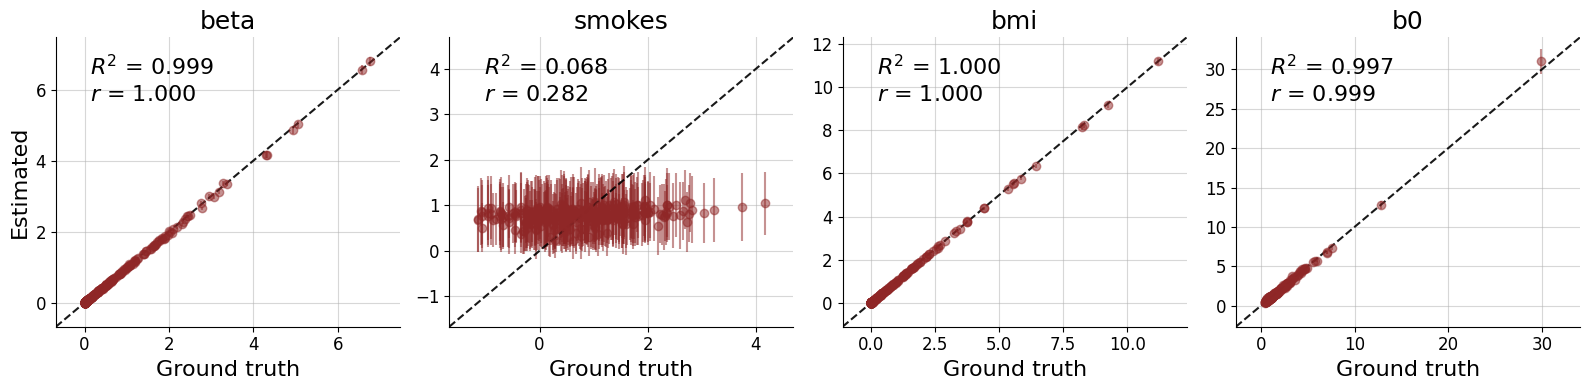

In [17]:
# Inspect parameter convergence
validation_sims = trainer.configurator(model(batch_size=300))
post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = bf.diagnostics.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)
print(validation_sims.keys())
params = validation_sims['parameters']
print(params.shape)

C:\Users\grajec\AppData\Local\Temp\ipykernel_19112\2148044779.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_data = training_data.replace({'yes': 1, 'no': 0})
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final

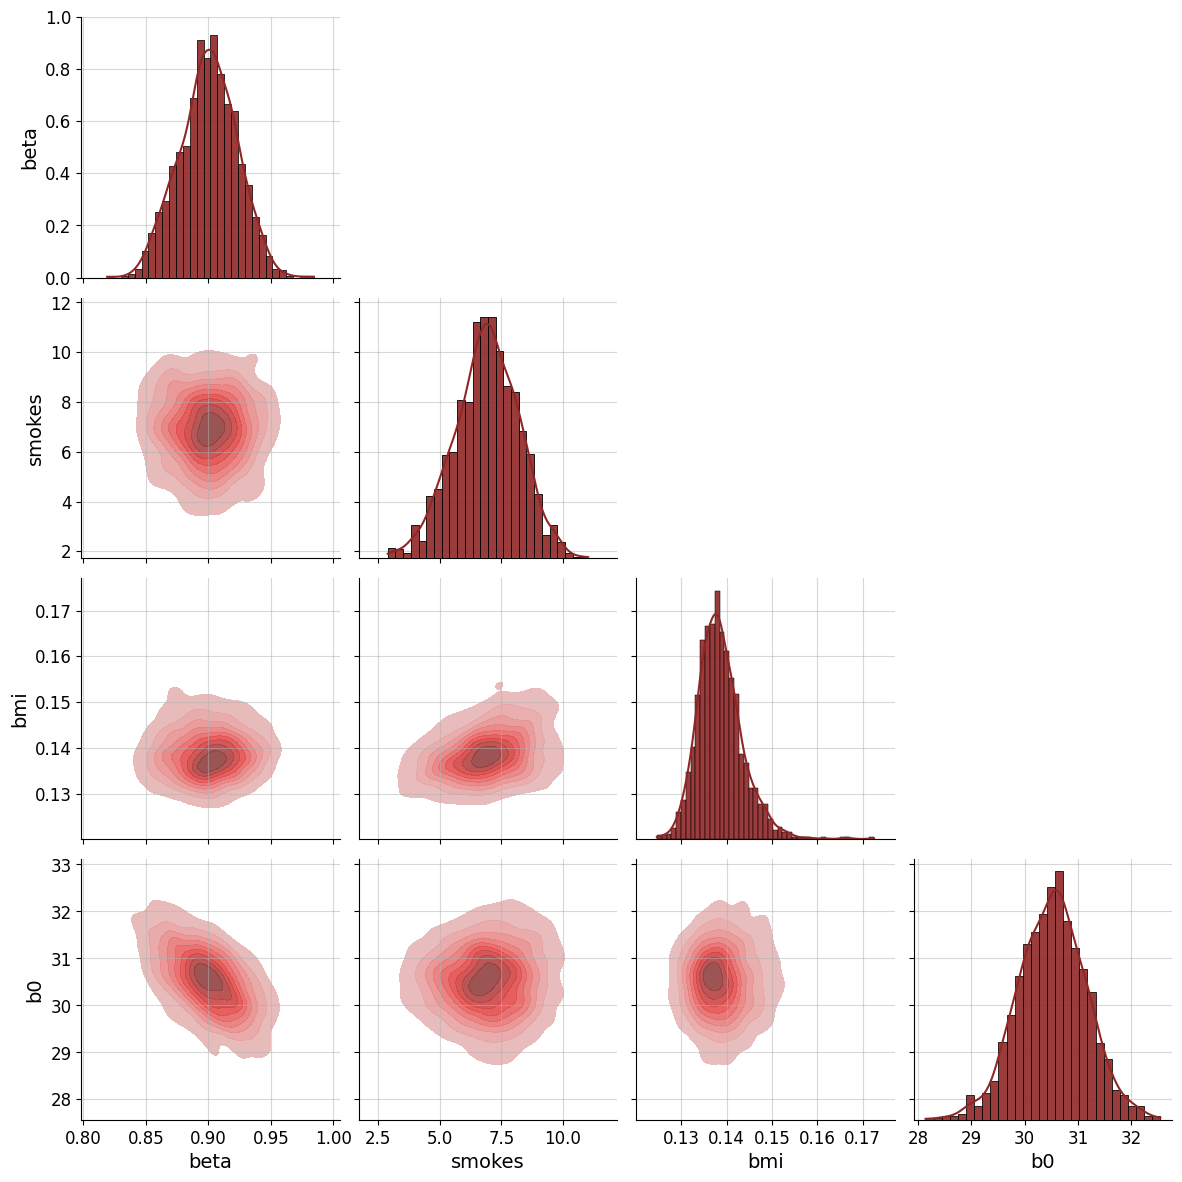

In [18]:
# Inspect trained posterior against real data
training_data = data
training_data = training_data.replace({'yes': 1, 'no': 0})
training_data = training_data.drop(columns=["sex", "region", "children"])
training_data.charges = (training_data.charges - training_data.charges.mean()) / training_data.charges.std()
training_data = training_data.to_numpy()

post_samples = amortizer.sample({'summary_conditions': np.asarray([training_data])}, n_samples=1338)
f = bf.diagnostics.plot_posterior_2d(post_samples, param_names=prior.param_names)

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seabor

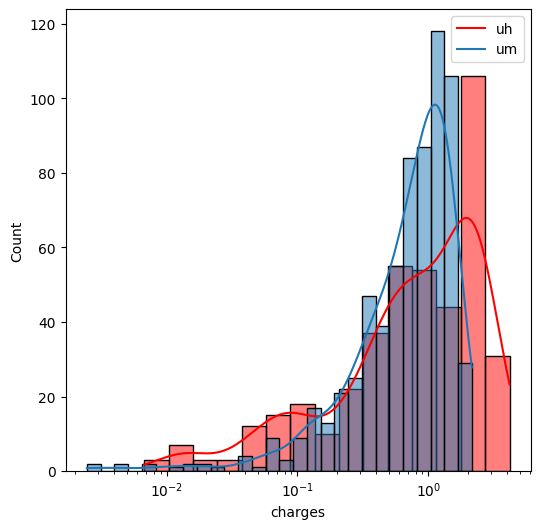

In [19]:
# Compare learned distribution against actual
n_samples = post_samples.shape[0]
avg_beta = sum(sample[0] for sample in post_samples) / n_samples
avg_s = sum(sample[1] for sample in post_samples) / n_samples
avg_bmi = sum(sample[2] for sample in post_samples) / n_samples
avg_b0 = sum(sample[3] for sample in post_samples) / n_samples

learned_data = np.zeros((n_samples, 1))
ages = rng.uniform(18, 65, size=n_samples)
bmis = rng.normal(30, 3, size=n_samples)
smokes = rng.binomial(1, 0.2, size=n_samples)
sexes = rng.binomial(1, 0.5, size=n_samples)
for i in range(n_samples):
    learned_data[i] = (avg_beta * ages[i]) + (avg_s * smokes[i]) + (avg_bmi * bmis[i]) + avg_b0

fig, ax = plt.subplots(1,1,figsize=(6,6))
norm_charges = (data.charges - data.charges.mean()) / data.charges.std()
learned_data = (learned_data - learned_data.mean()) / learned_data.std()
sns.histplot(norm_charges, log_scale=True, color='red', kde=True, ax=ax)
sns.histplot(learned_data, log_scale=True, color='blue', kde=True, ax=ax)
ax.legend(labels=["uh", "um"])

### Data Inspection

<Axes: xlabel='age', ylabel='charges'>

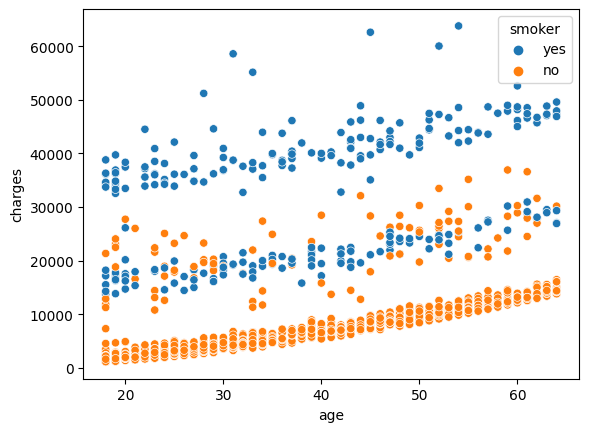

In [21]:
sns.scatterplot(data=data, x='age', y='charges', hue="smoker")

<Axes: xlabel='bmi', ylabel='charges'>

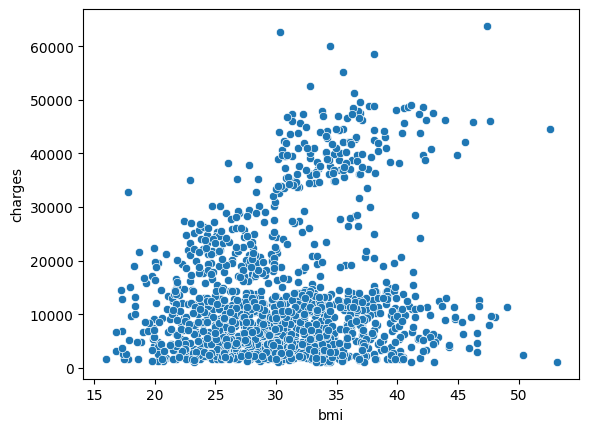

In [23]:
sns.scatterplot(data=data, x='bmi', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0, 0.5, ''), []]

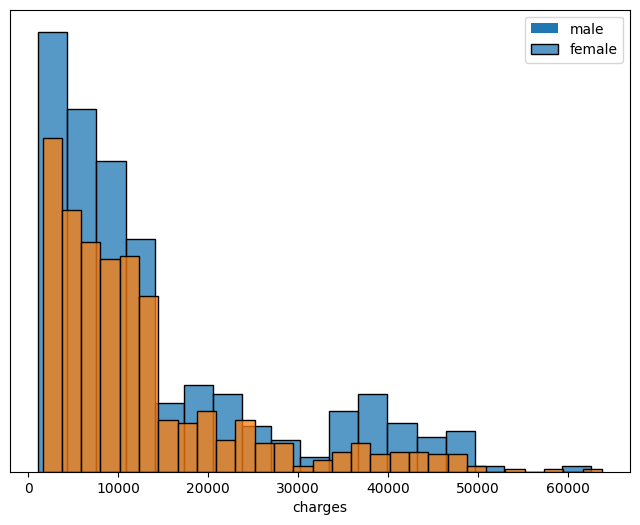

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.histplot(data[data['sex']=='male']['charges'], ax=ax)
sns.histplot(data[data['sex']=='female']['charges'], ax=ax)
ax.legend(labels=["male", "female"])
ax.set(ylabel="", yticks=[])

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0, 0.5, ''), []]

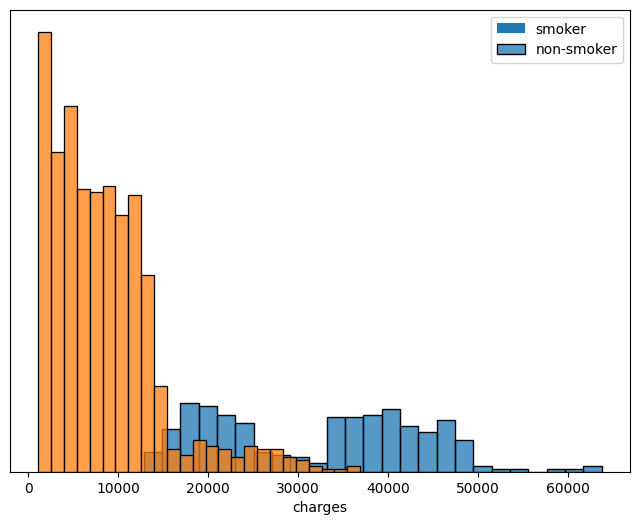

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.histplot(data[data['smoker']=='yes']['charges'], bins=25, ax=ax)
sns.histplot(data[data['smoker']=='no']['charges'], bins=25, ax=ax)
ax.legend(labels=["smoker", "non-smoker"])
ax.set(ylabel="", yticks=[])

<Axes: xlabel='children', ylabel='charges'>

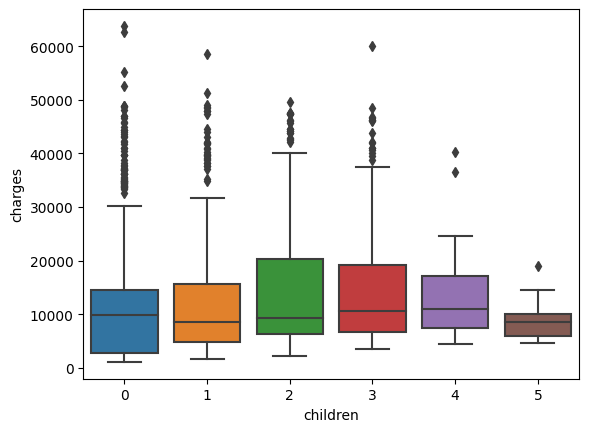

In [26]:
sns.boxplot(data=data, x='children', y='charges')

<Axes: xlabel='region', ylabel='charges'>

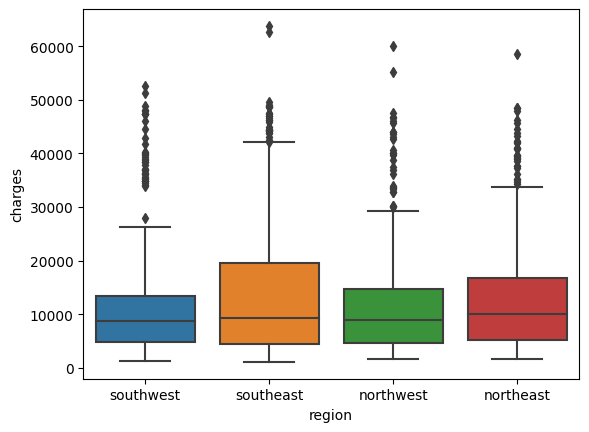

In [27]:
sns.boxplot(data=data, x='region', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

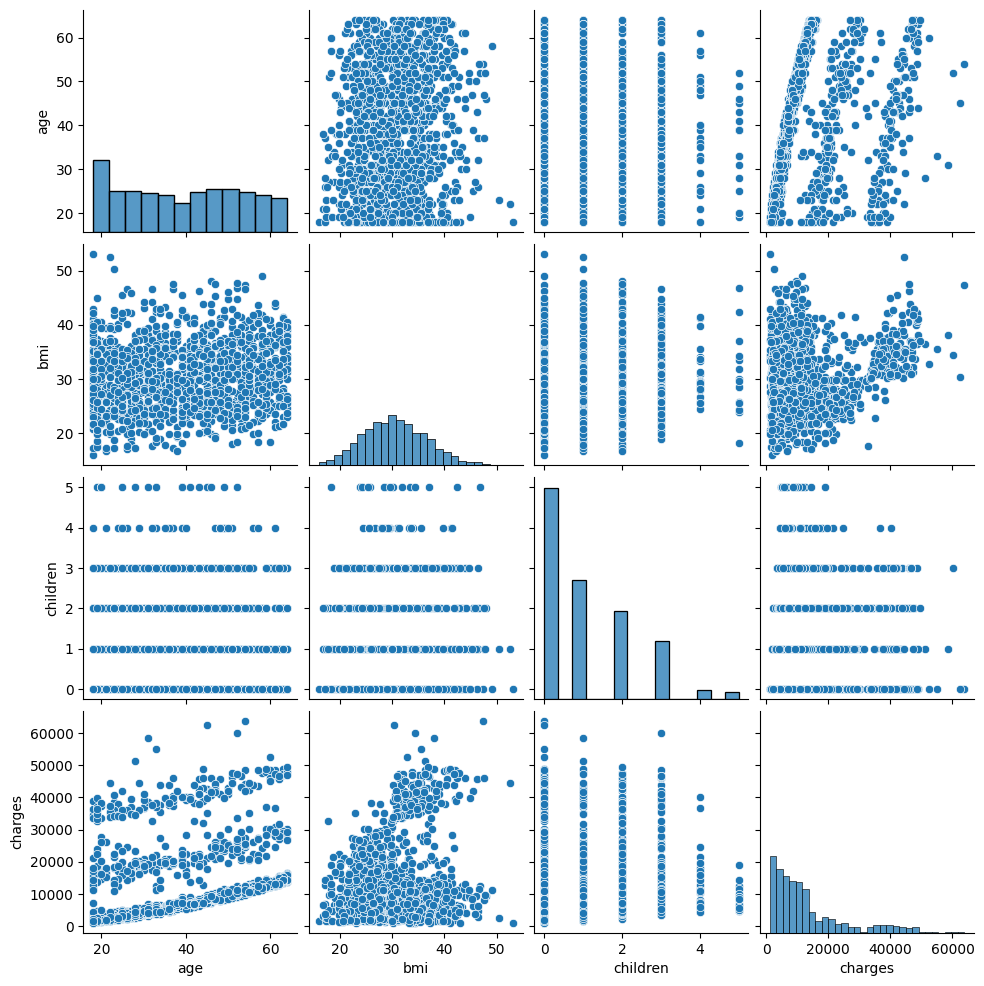

In [28]:
sns.pairplot(data)

C:\Users\grajec\AppData\Local\Temp\ipykernel_19112\574572776.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.replace({'female': 0, 'male': 1, 'no': 0, 'yes': 1, 'northeast': 0, 'southeast': 1, 'southwest': 2, 'northwest': 3})


<Axes: >

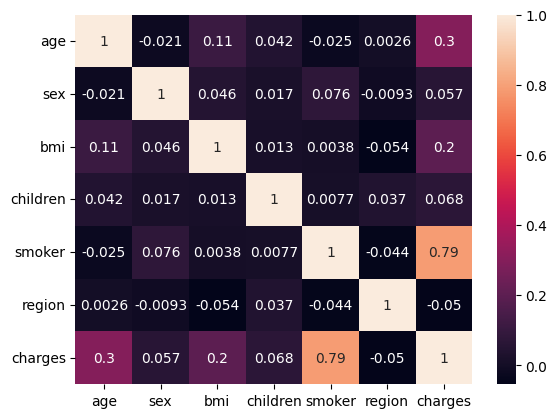

In [29]:
heatmap_data = data
heatmap_data = heatmap_data.replace({'female': 0, 'male': 1, 'no': 0, 'yes': 1, 'northeast': 0, 'southeast': 1, 'southwest': 2, 'northwest': 3})
corr = heatmap_data.corr()
sns.heatmap(corr, annot=True)